In [12]:
import george
from george import kernels
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = "retina"
from matplotlib import rcParams
rcParams['savefig.dpi'] = 550
rcParams['font.size'] = 20
plt.rc('font', family='serif')

import emcee
from corner import corner

/Users/andytzanidakis/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
from george.modeling import Model as mgo

class Model(mgo):
    parameter_names = ("amp", "location", "log_sigma2")
    
    def get_value(self, t): 
        return self.amp * np.exp(-0.5*(t.flatten()-self.location)**2 * np.exp(-self.log_sigma2))

In [57]:
def fake_data(params, N, rng=(-10, 10)):
    gp = george.GP(0.1 * kernels.ExpSquaredKernel(3.3))
    t = rng[0] + np.diff(rng) * np.sort(np.random.rand(N))
    y = gp.sample(t)
    y += Model(**params).get_value(t)
    yerr = 0.00005 + 0.001 * np.random.randint(N)
    yerr += 0.1 * abs(yerr * np.random.normal(0, 1, N))
    return t, y, yerr

In [58]:
true = dict(amp=-1, location=0, log_sigma2=np.log(0.4))

In [102]:
t, y, yerr = fake_data(true, 25)
yerr *= 4.2

In [105]:
yerr *= 0.5

<ErrorbarContainer object of 3 artists>

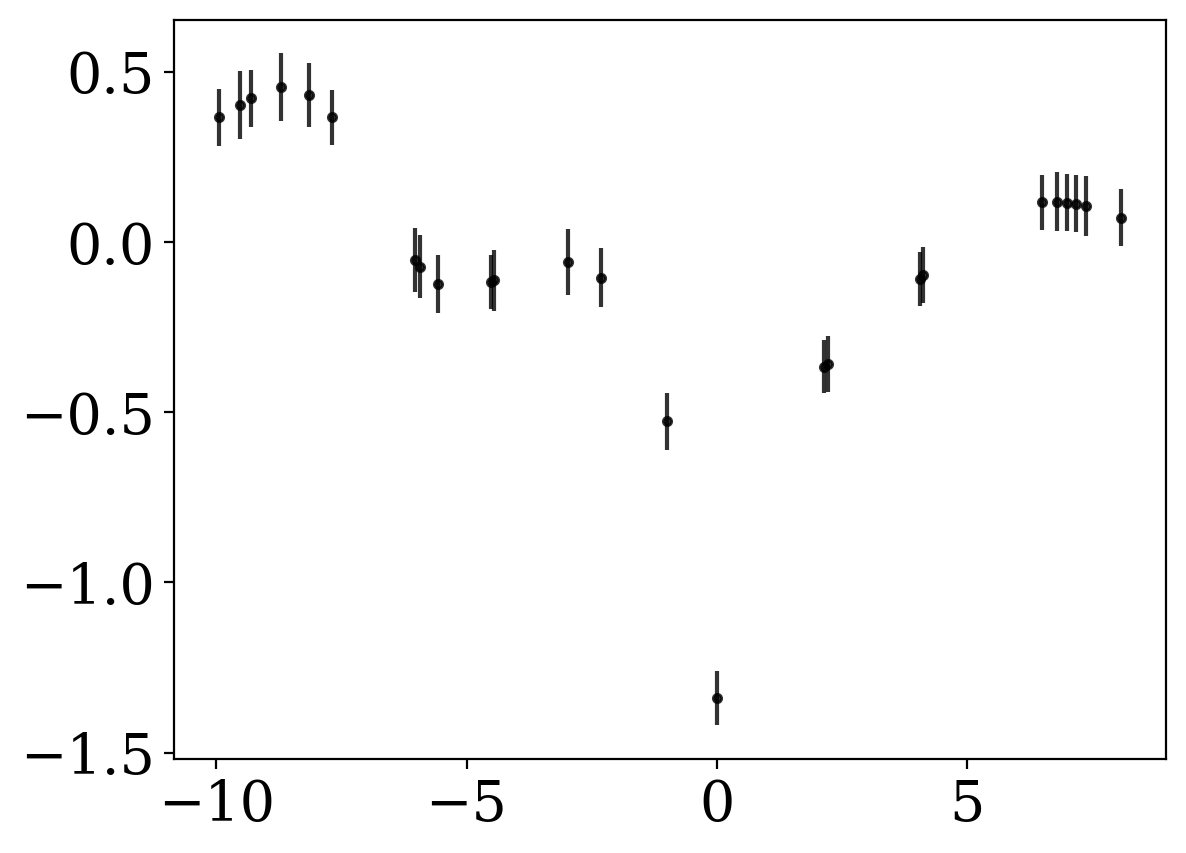

In [106]:
plt.errorbar(t, y, yerr,
             fmt='.', color='k', alpha=0.8)

In [11]:
class PolynomialModel(mgo): 
    parameter_names = ("m", "b", "amp", "location", "log_sigma2")

    def get_value(self, t):
        t = t.flatten()
        return (t * self.m + self.b + 
               self.amp * np.exp(-0.5*(t-self.location)**2 * np.exp(-self.log_sigma2)))

In [505]:
model = george.GP(mean=PolynomialModel(m=0, 
                                      b=0, 
                                      amp=-1, 
                                      location=0.1, 
                                      log_sigma2=np.log(0.4)))
model.compute(t, yerr)

In [506]:
def lnprob(p):
    model.set_parameter_vector(p)
    return model.log_likelihood(y, quiet=True) + model.log_prior()

In [507]:
from corner import corner
import emcee

In [508]:
init = model.get_parameter_vector()
ndim, nwalkers = len(init), 32
p0 = init + 1e-8 * np.random.rand(nwalkers, ndim)
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)

In [509]:
p0, _ , _ = sampler.run_mcmc(p0, 200)
sampler.reset()

In [510]:
sampler.run_mcmc(p0, 500)

State([[ 8.67055923e-03  7.62741345e-02 -1.85304382e+00  9.95766190e-01
   4.74707558e-01]
 [ 7.30510666e-03  1.18465030e-01 -2.77866880e+00  1.02611951e+00
   1.93516266e-01]
 [ 6.82800366e-03  1.15926384e-01 -3.44910742e+00  1.03696104e+00
   3.56170835e-02]
 [ 9.63938742e-03  1.05300059e-01 -2.95586180e+00  1.00119478e+00
   1.39081046e-01]
 [ 1.00258325e-02  8.49240165e-02 -2.75416859e+00  1.02067009e+00
   1.66216846e-01]
 [ 9.33450212e-03  1.00201536e-01 -3.65425806e+00  1.01874847e+00
  -2.38831989e-02]
 [ 8.15276055e-03  8.91608261e-02 -2.20024126e+00  1.00486652e+00
   3.19884944e-01]
 [ 5.06252258e-03  1.11582604e-01 -1.94704969e+00  9.88758994e-01
   4.75961372e-01]
 [ 7.30243561e-03  9.60981019e-02 -2.52846043e+00  9.99053162e-01
   2.19084270e-01]
 [ 9.69871806e-04  1.34422949e-01 -2.20804726e+00  9.87039769e-01
   3.83145945e-01]
 [ 7.61136010e-03  1.16427678e-01 -2.26604861e+00  1.03235168e+00
   3.67343206e-01]
 [ 4.43044599e-03  1.15623351e-01 -2.20859740e+00  9.851907

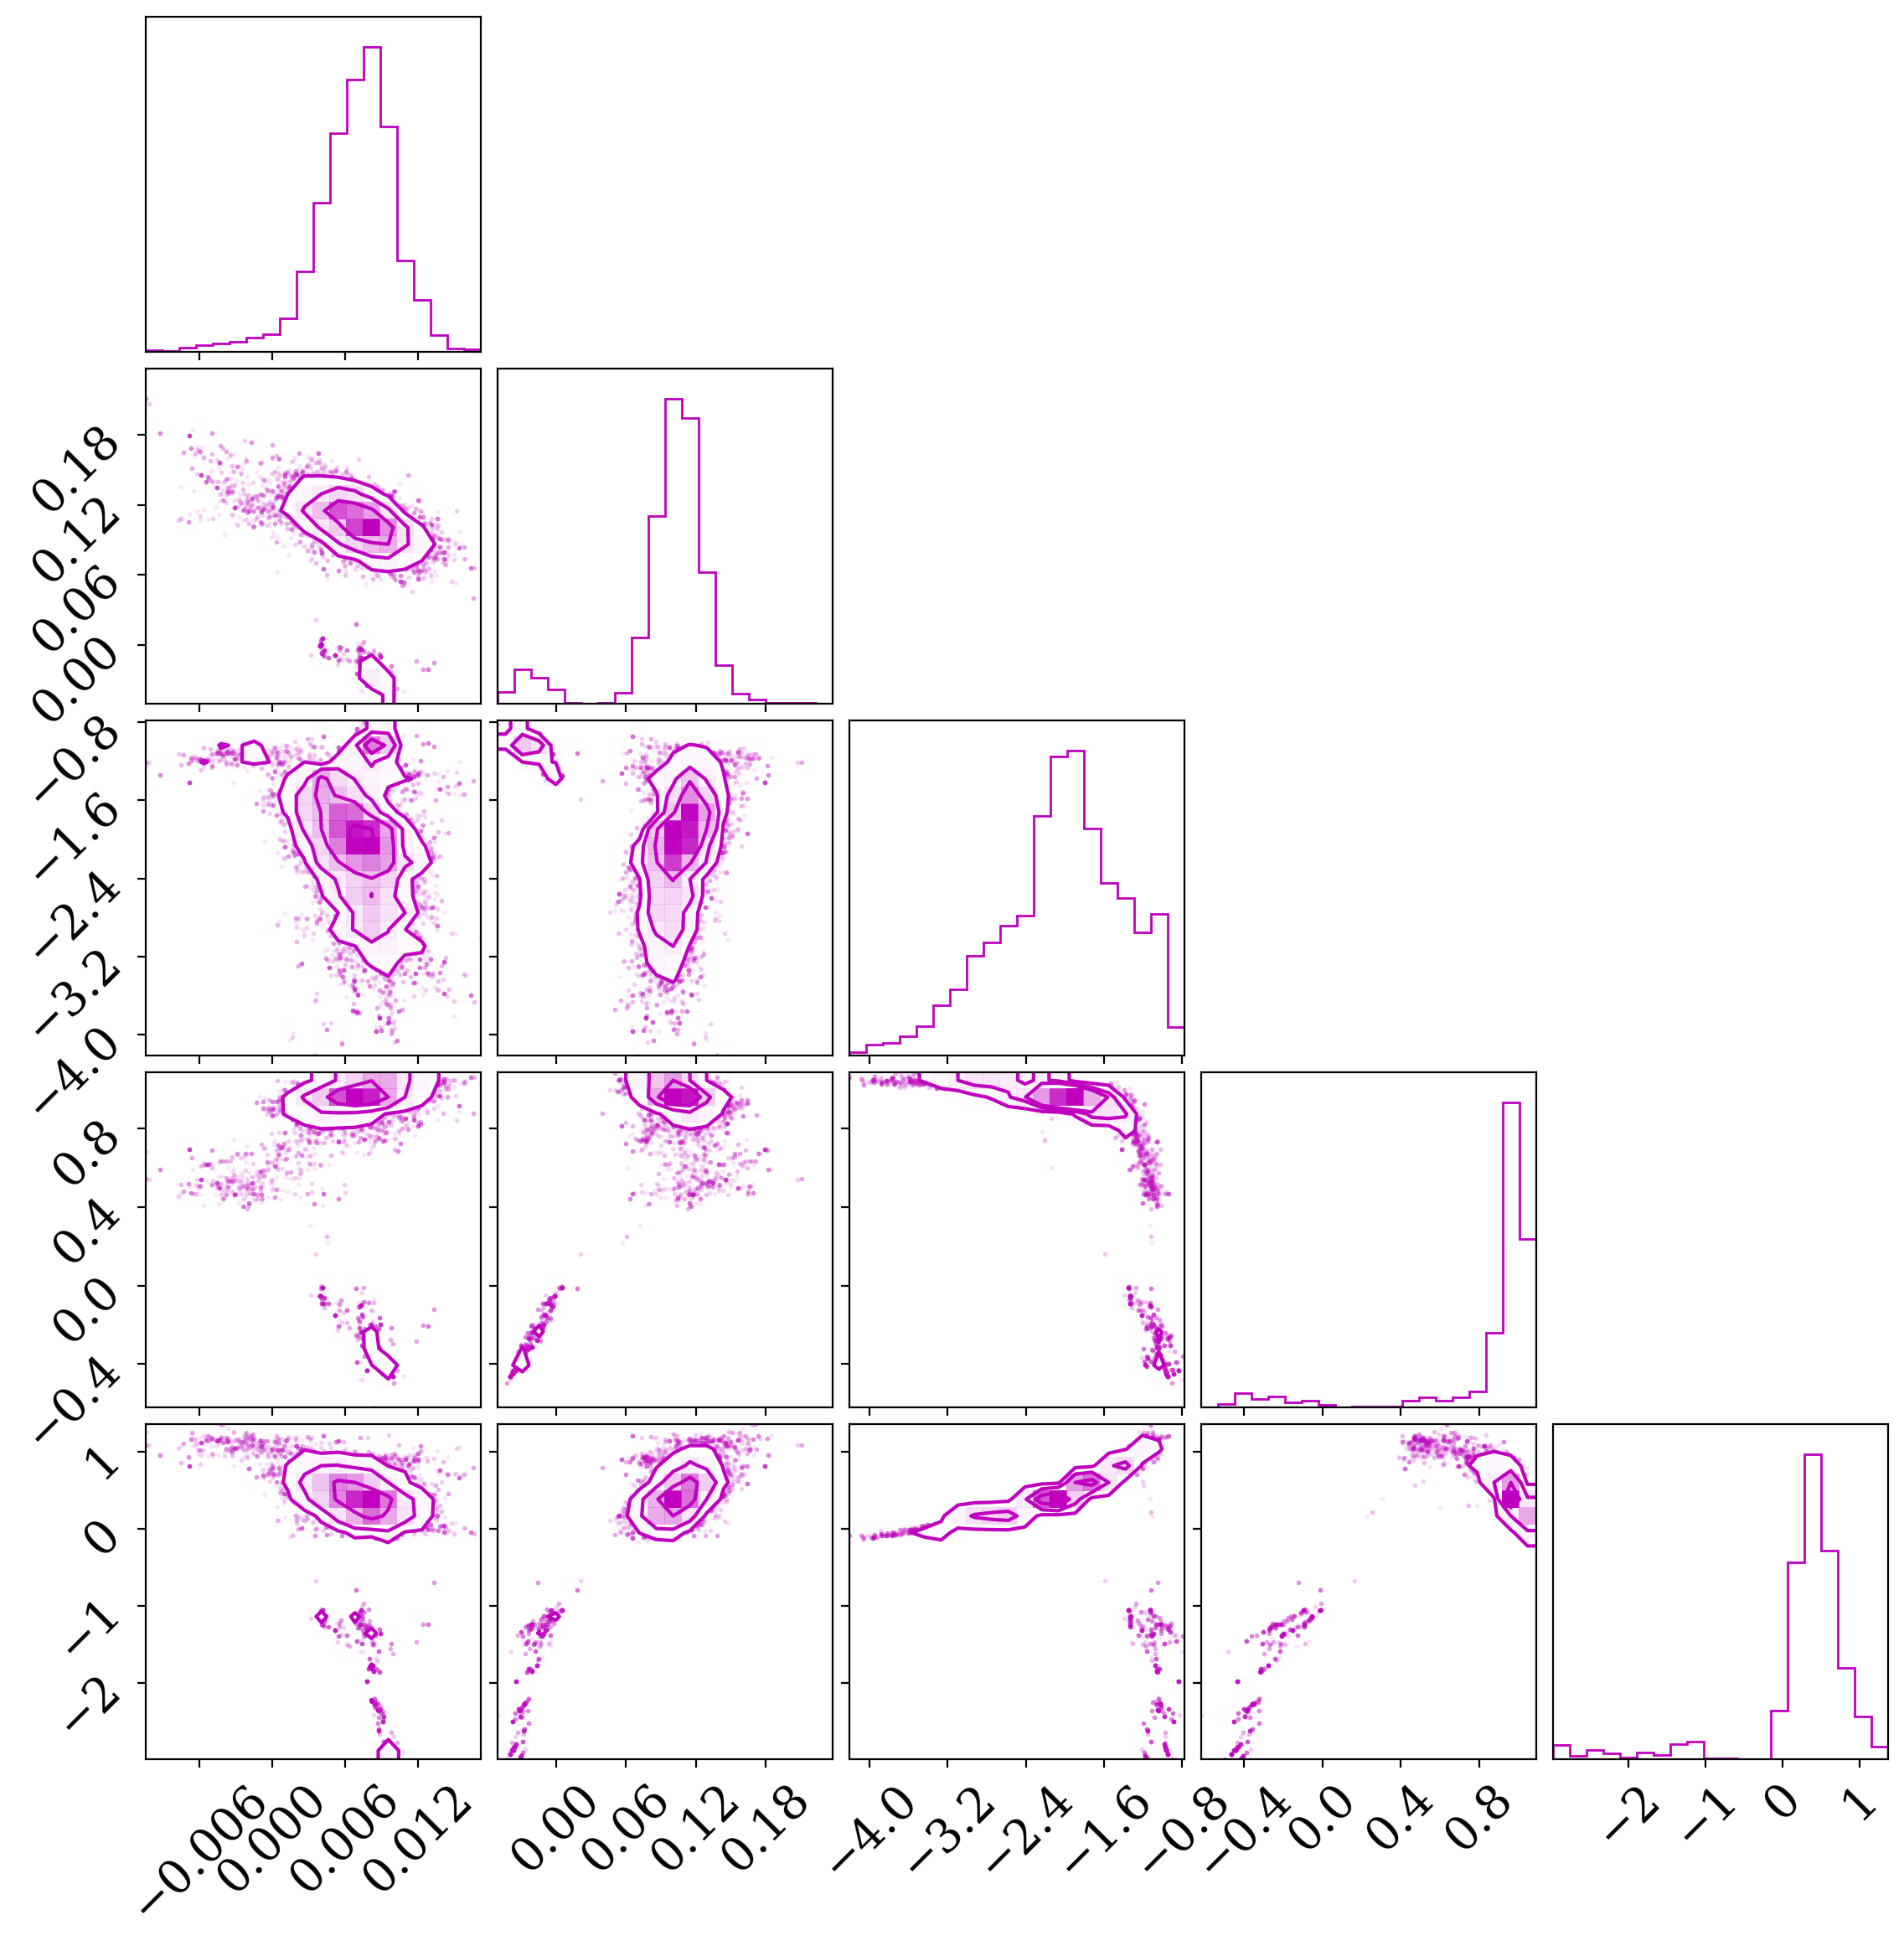

In [511]:
_ = corner(sampler.flatchain, color='m')

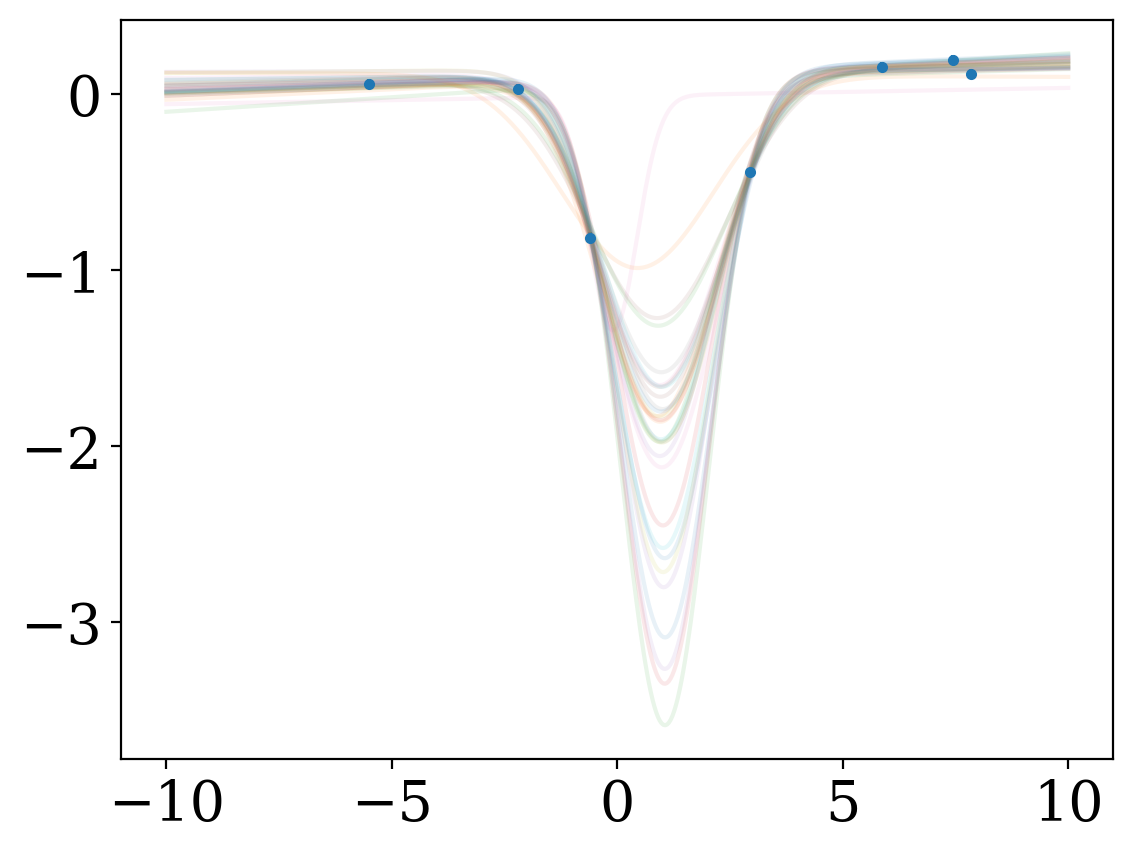

In [512]:
plt.errorbar(t, y, yerr, fmt='.')

x = np.linspace(-10, 10, 500)

samples = sampler.flatchain
for s in samples[np.random.randint(len(samples), size=30)]:
    model.set_parameter_vector(s)
    plt.plot(x, model.mean.get_value(x), alpha=0.1)

In [513]:
kwargs = dict(**true)
kwargs["bounds"] = dict(location=(-2, 2)) # adding boundaries to the location...

In [514]:
kwargs = dict(**true)
kwargs["bounds"] = dict(location=(-2, 2)) # adding boundaries to the location...
mean_model = Model(**kwargs)

In [515]:
gp = george.GP(np.var(y) * kernels.Matern32Kernel(10), mean=mean_model)

In [516]:
gp.compute(t, yerr)

In [517]:
def lnprob2(p):
    gp.set_parameter_vector(p)
    return gp.log_likelihood(y, quiet=True) + gp.log_prior

In [518]:
init = model.get_parameter_vector()
ndim, nwalkers = len(init), 32
p0 = init + 1e-8 * np.random.rand(nwalkers, ndim)
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)

In [519]:
p0, lp , _ = sampler.run_mcmc(p0, 1_000)
sampler.reset()

In [520]:
p0 = p0[np.argmax(lp)] + 1e-8 * np.random.randn(nwalkers, ndim)
sampler.reset()
p0, lp , _ = sampler.run_mcmc(p0, 1_000)
sampler.reset()

In [521]:
sampler.run_mcmc(p0, 1_000)

State([[ 1.09897595e-02  7.82151897e-02 -3.68658174e+00  1.02180585e+00
  -6.21952319e-02]
 [ 1.00620743e-02  8.33048869e-02 -7.66612692e+00  1.10504944e+00
  -4.01884319e-01]
 [ 4.25513729e-03  8.37548566e-02 -2.86200486e+00  1.02245545e+00
   1.01125347e-01]
 [ 1.11237107e-02  6.16725428e-02 -3.95846944e+00  1.05083225e+00
  -1.14798817e-01]
 [ 5.55856198e-03  1.15233950e-01 -2.51360587e+00  1.00343005e+00
   2.72104244e-01]
 [ 9.00491987e-03  9.51917370e-02 -2.41359186e+00  9.82700428e-01
   2.71412436e-01]
 [ 4.25859473e-03  8.76001620e-02 -2.32815509e+00  9.93337153e-01
   2.97560324e-01]
 [ 8.30988365e-03  8.84878162e-02 -1.84103063e+00  9.79193001e-01
   5.07335502e-01]
 [ 1.09888695e-02  7.53042106e-02 -5.55907541e+00  1.09284207e+00
  -2.44325127e-01]
 [ 9.79780256e-03  9.50637483e-02 -3.78532794e+00  1.02970202e+00
  -4.15724505e-02]
 [ 7.01571996e-03  1.21746573e-01 -2.15583133e+00  9.64354096e-01
   4.28943985e-01]
 [ 1.24652188e-02  7.67053652e-02 -3.61874674e+00  1.028204

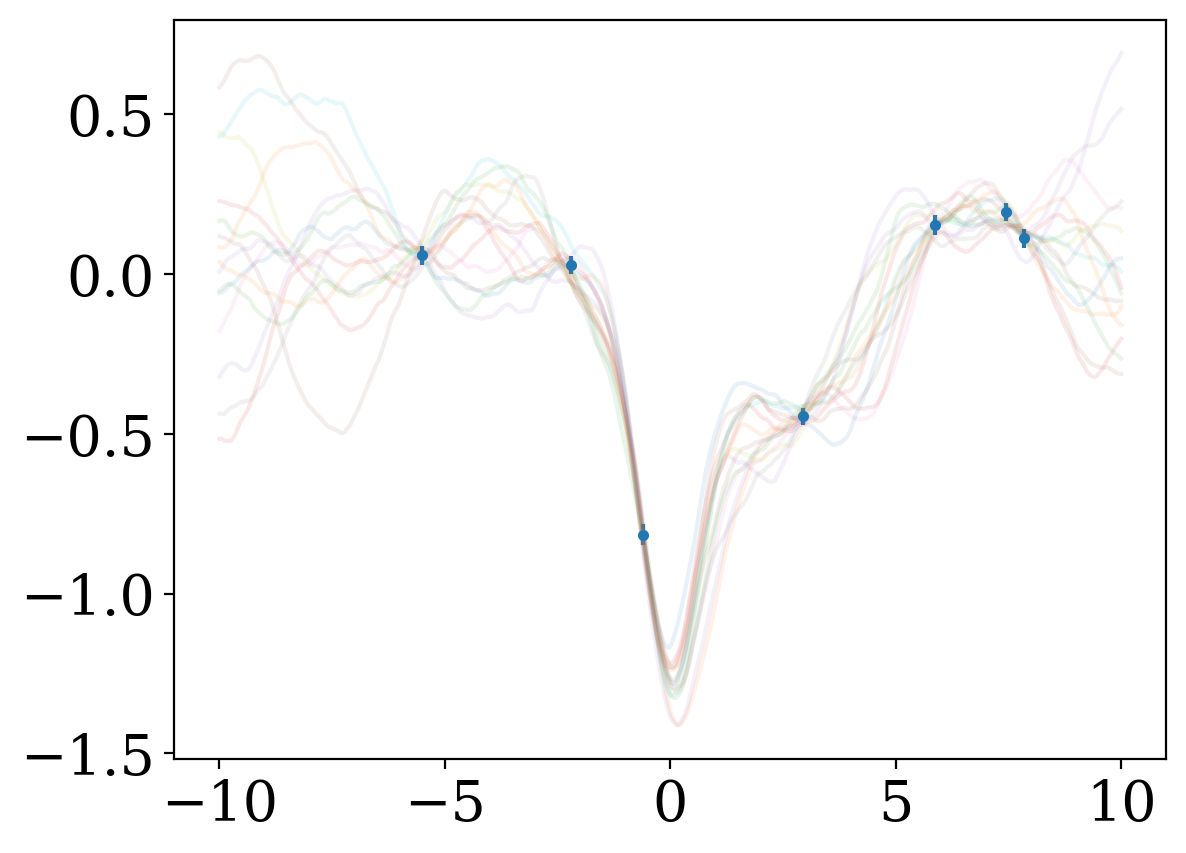

In [522]:
plt.errorbar(t, y, yerr, fmt='.')

x = np.linspace(-10, 10, 500)

samples = sampler.flatchain
for s in samples[np.random.randint(len(samples), size=15)]:
    model.set_parameter_vector(s)
    mu = gp.sample_conditional(y, x)
    plt.plot(x, mu, alpha=0.1)

In [523]:
bestm = []
for i in range(5):
     bestm.append(np.median(sampler.flatchain[:,i]))

In [524]:
bestm

[0.007810268328985178,
 0.09830064932714126,
 -2.5559882670713394,
 1.009845231997007,
 0.22492675386377084]

In [525]:
model.set_parameter_vector(bestm)

In [526]:
model.set_parameter_vector(bestm)
model_best = gp.sample_conditional(y, x)

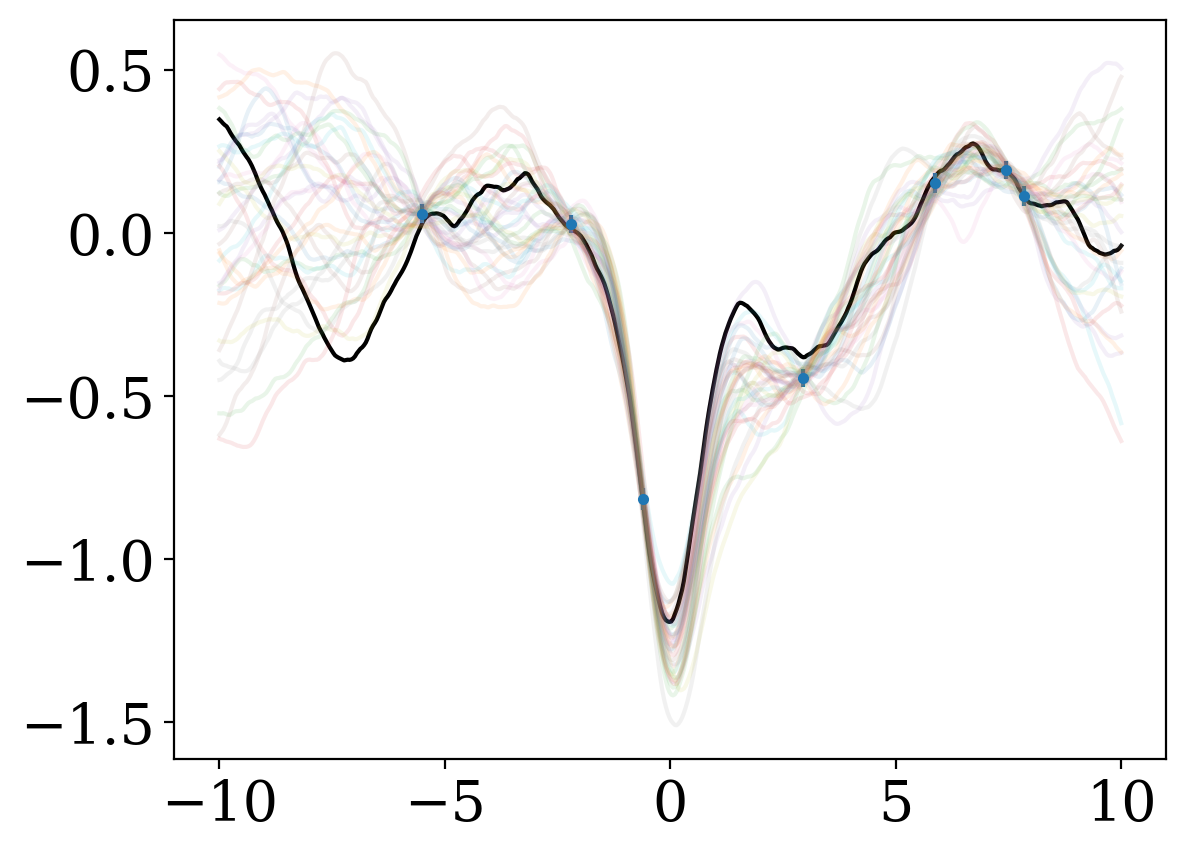

In [527]:
plt.plot(x, model_best, color='k')

plt.errorbar(t, y, yerr, fmt='.')

x = np.linspace(-10, 10, 500)

samples = sampler.flatchain
for s in samples[np.random.randint(len(samples), size=35)]:
    model.set_parameter_vector(s)
    mu = gp.sample_conditional(y, x)
    plt.plot(x, mu, alpha=0.1)

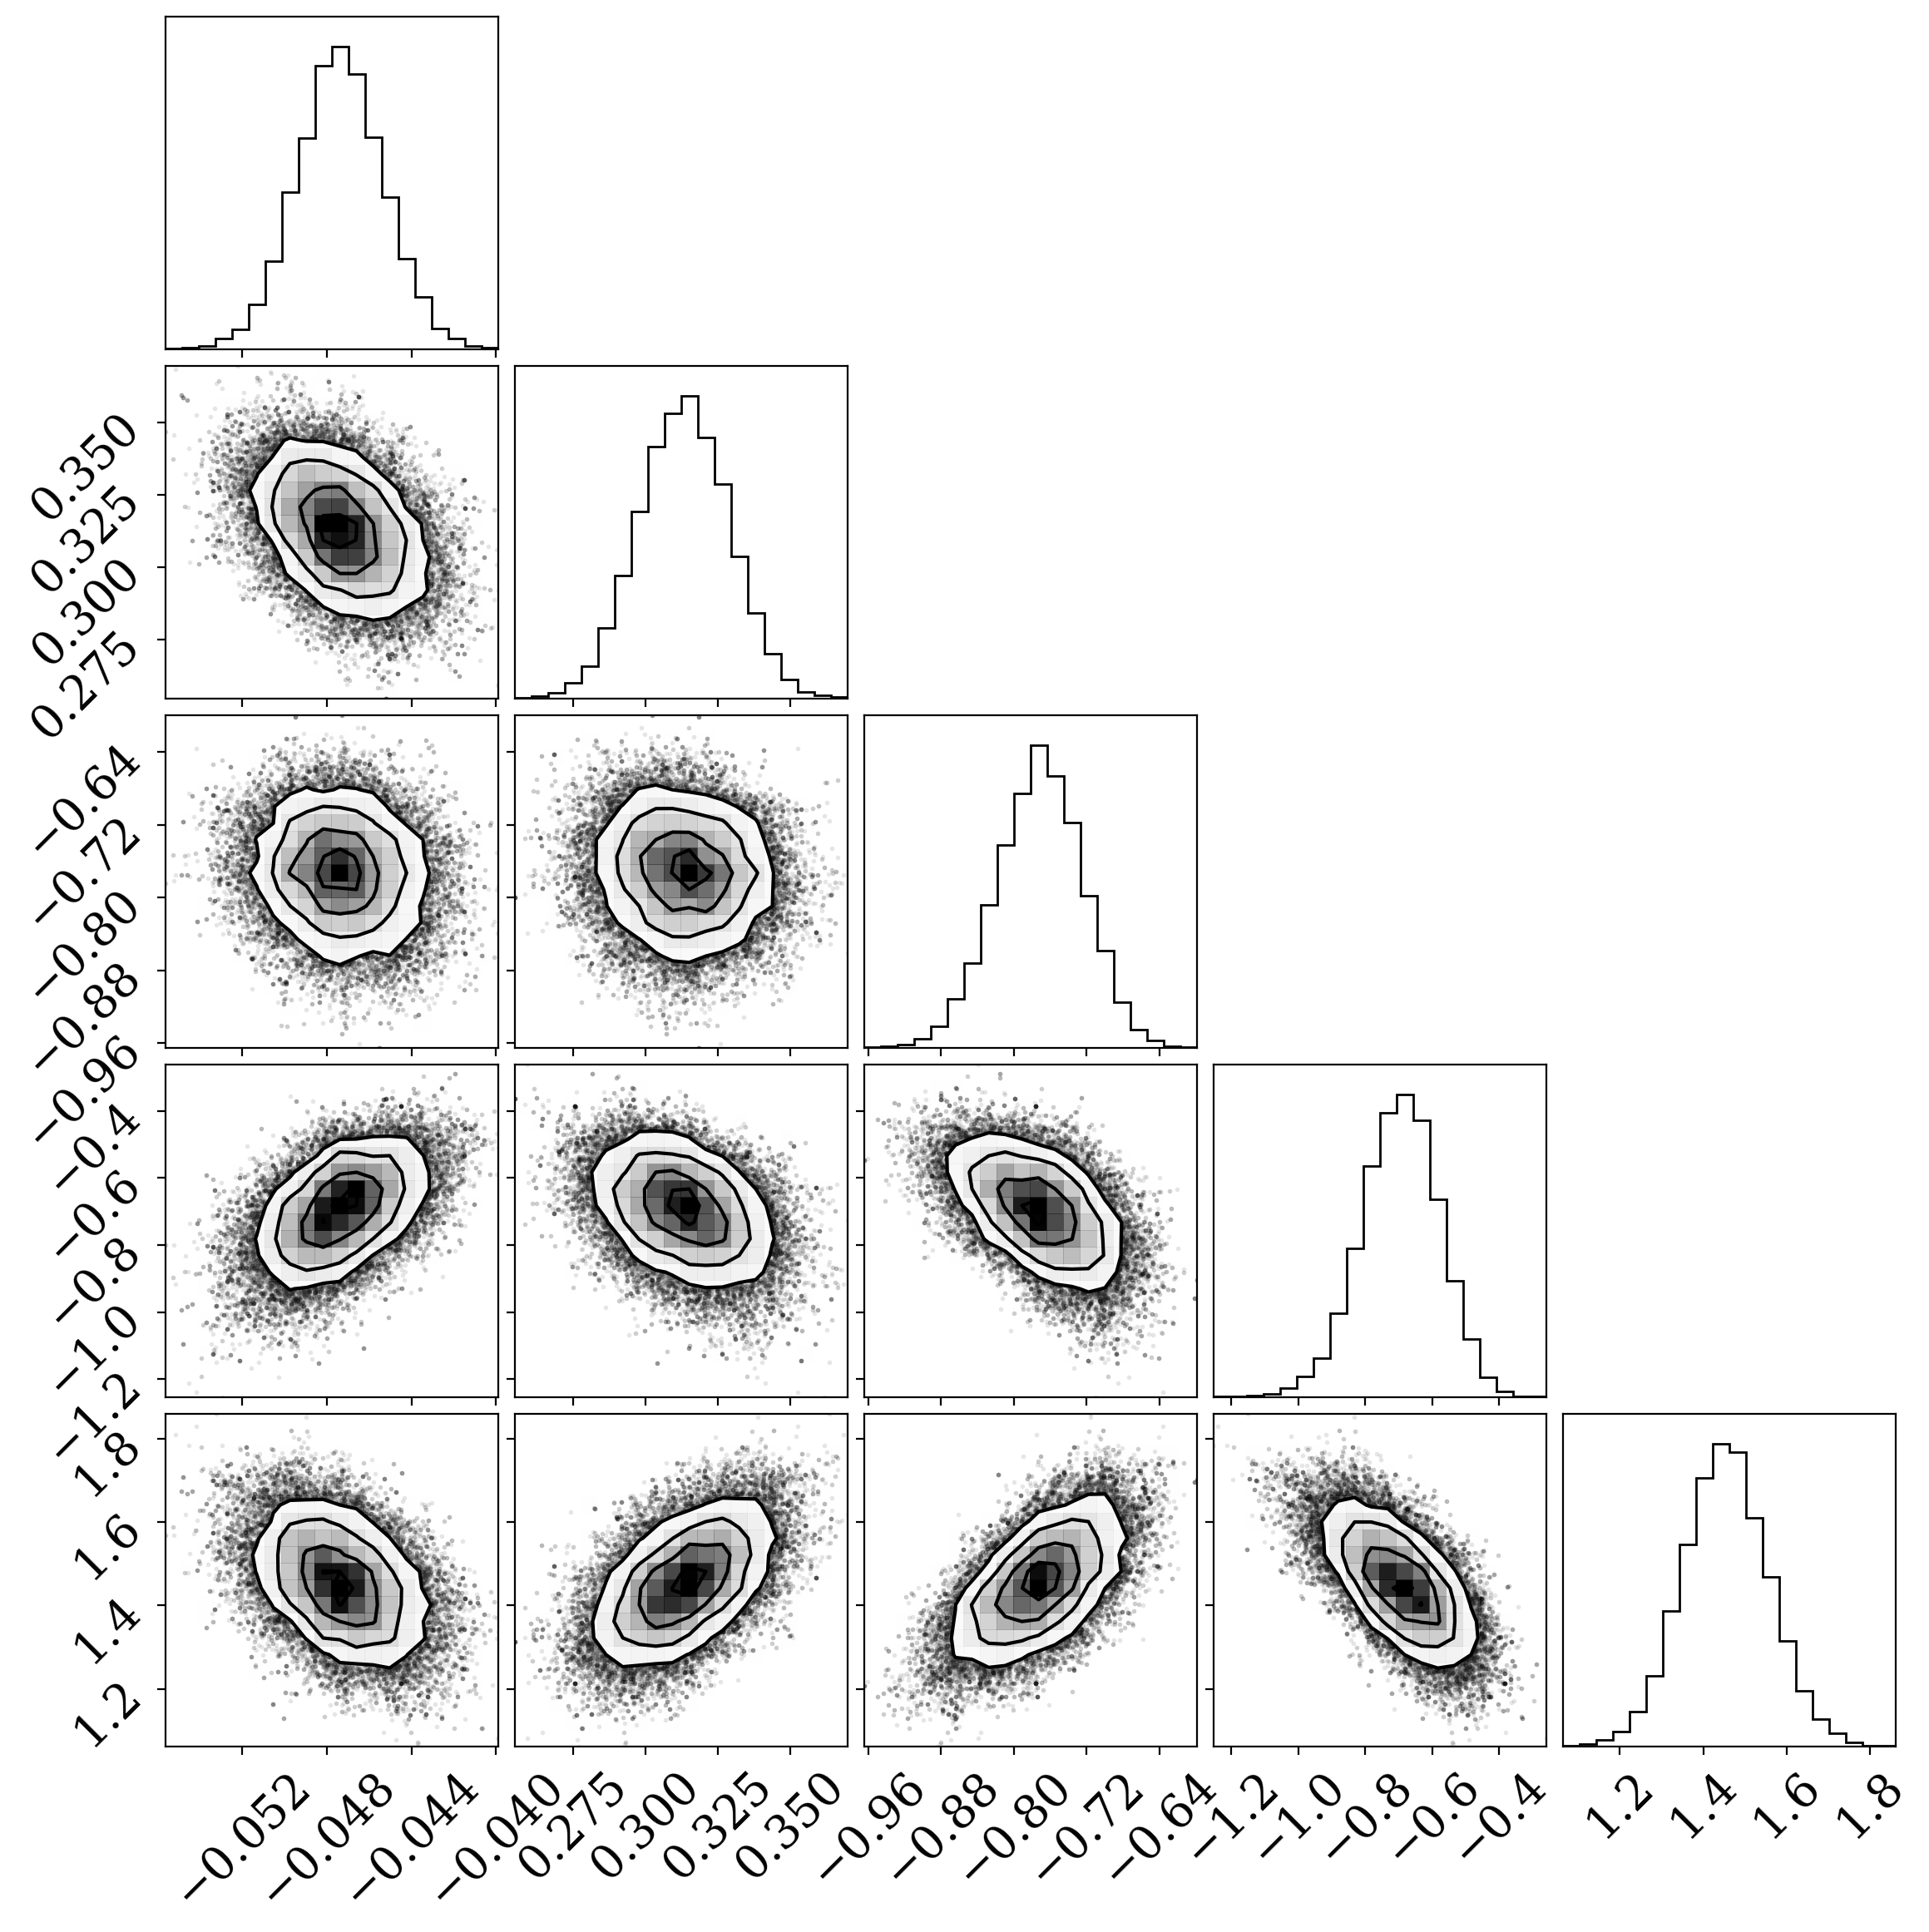

In [339]:
_ = corner(sampler.flatchain)

In [288]:
parameter_names = ("m", "b", "amp", "location", "log_sigma2")

for i in range(5):
    print (parameter_names[i],':', np.median(sampler.flatchain[:,i]))

m : -0.03677012424614955
b : 0.4603165936444026
amp : -1.345390626834101
location : 0.3402989487926956
log_sigma2 : -0.7849161144752511


In [297]:
names = gp.get_parameter_names()
tri_cols = ["amp", "location", "log_sigma2"]
tri_labels = ["a", "$\ell$", "$\sigma$"]
inds = np.array([names.index("mean:"+k) for k in tri_cols])

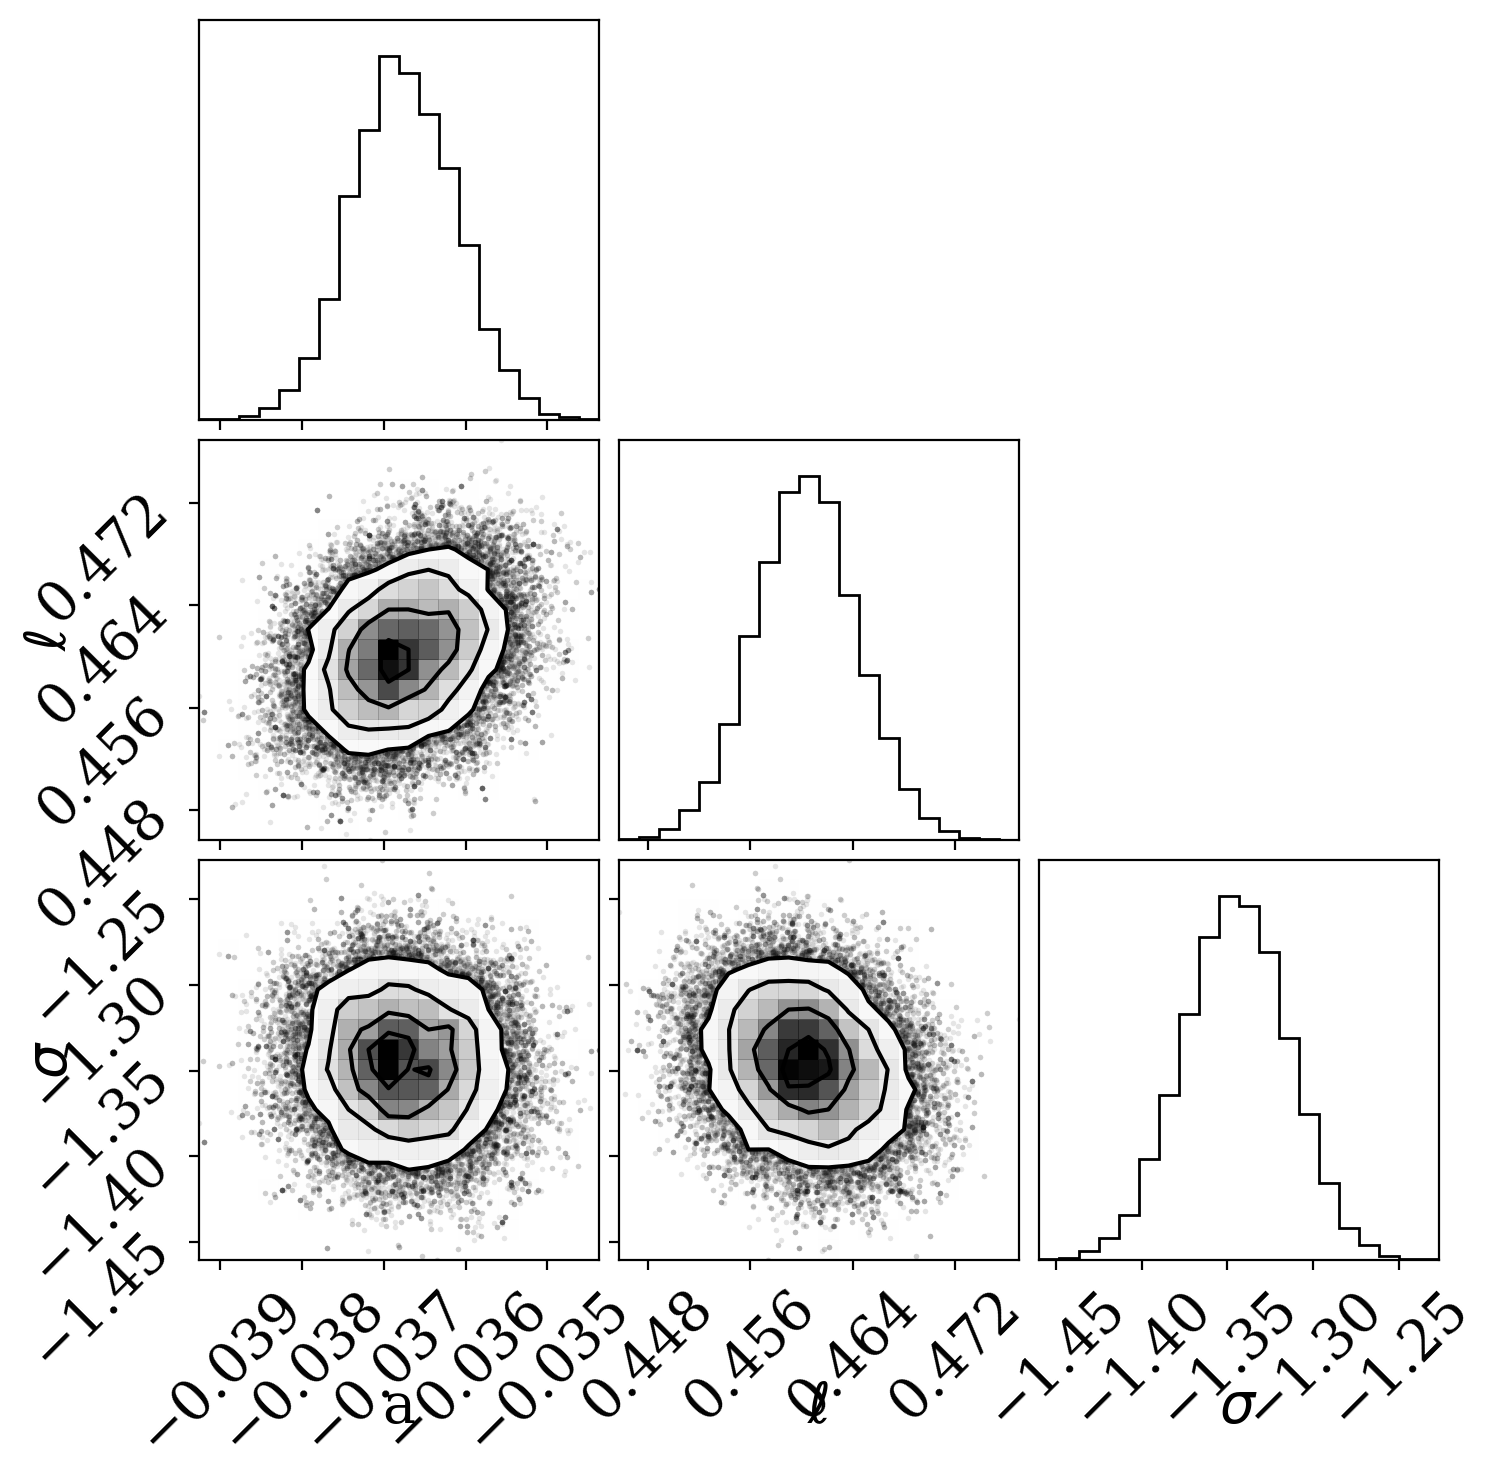

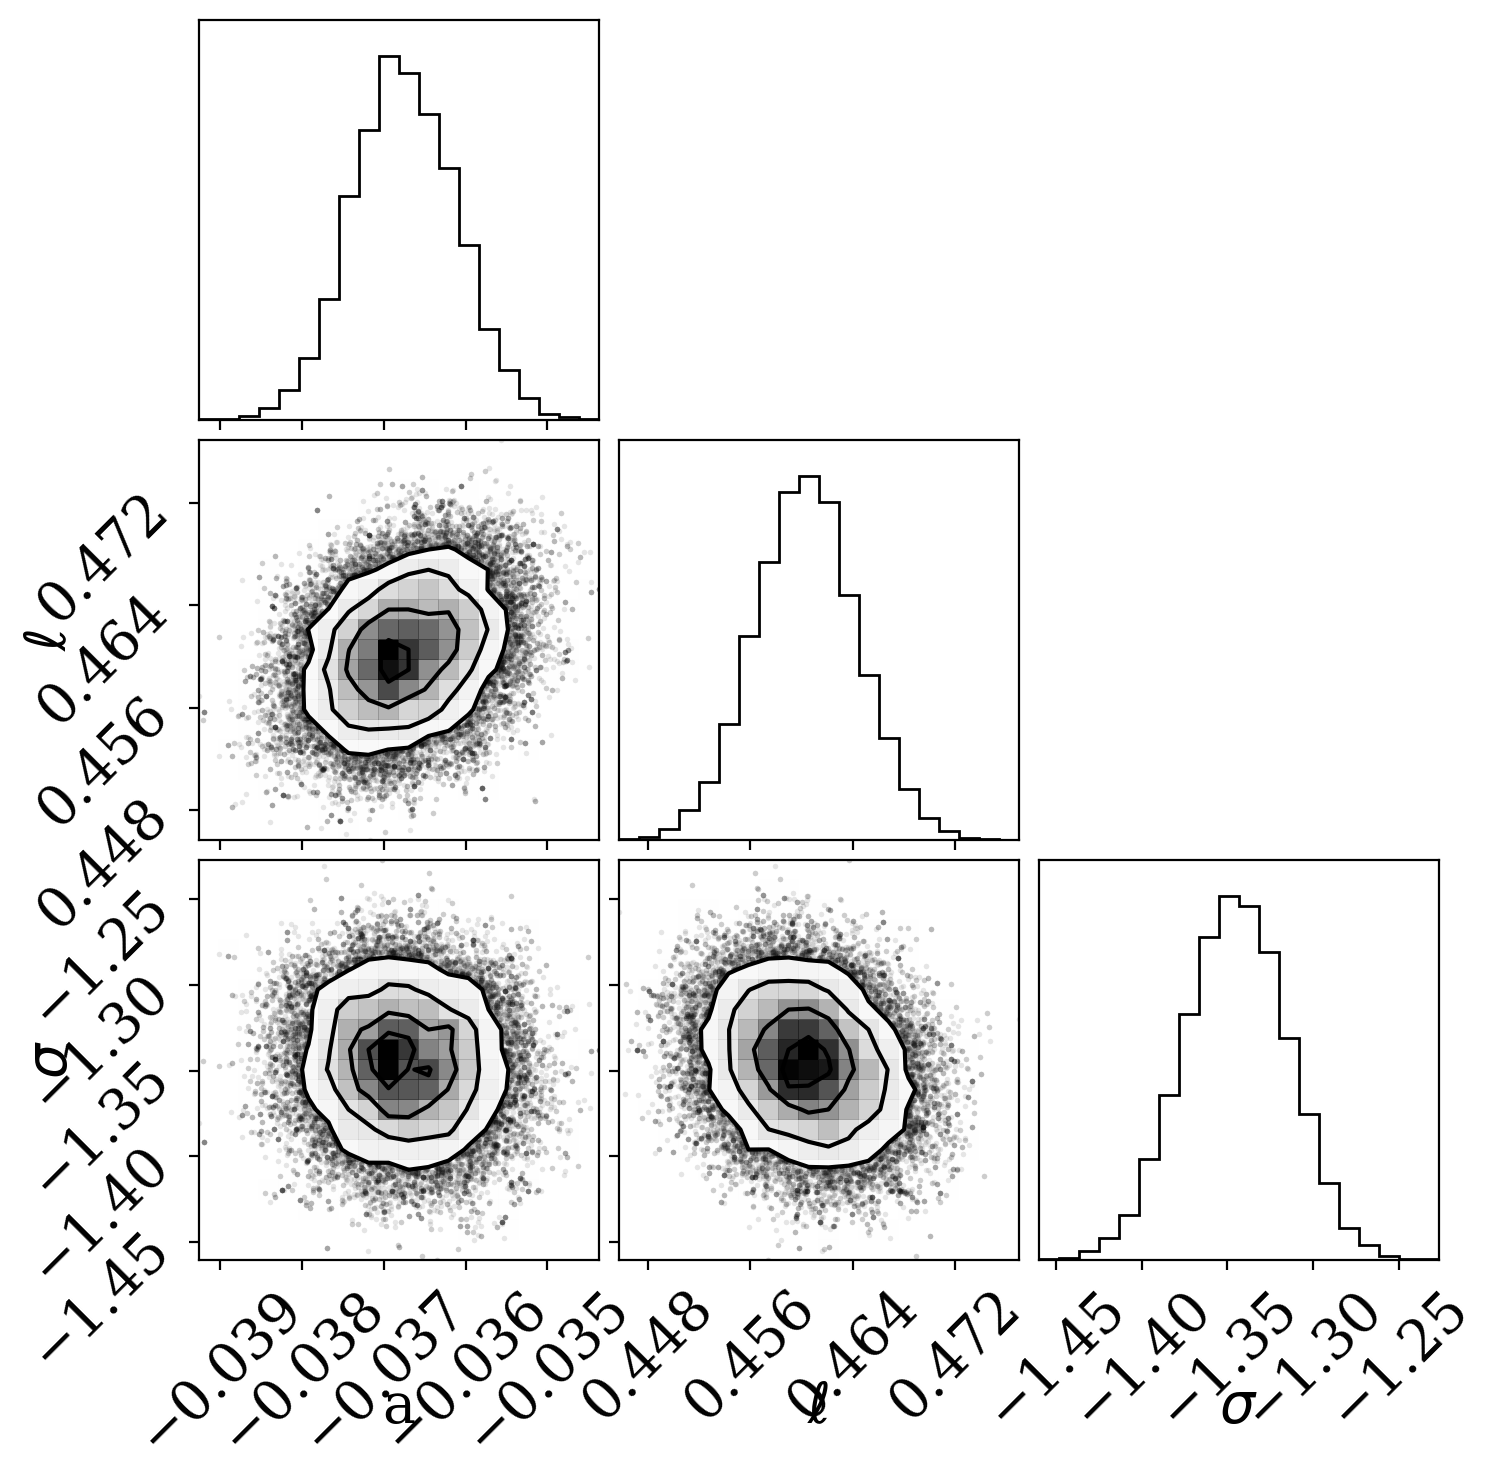

In [299]:
corner(sampler.flatchain[:, inds], labels=tri_labels)

## Implementation 

First use the polynomial Gaussian
```python

from george.modeling import Model as mgo

class Model(mgo):
    parameter_names = ("amp", "location", "log_sigma2")
    
    def get_value(self, t): 
        return self.amp * np.exp(-0.5*(t.flatten()-self.location)**2 * np.exp(-self.log_sigma2))



class PolynomialModel(mgo): 
    parameter_names = ("m", "b", "amp", "location", "log_sigma2")

    def get_value(self, t):
        t = t.flatten()
        return (t * self.m + self.b + 
               self.amp * np.exp(-0.5*(t-self.location)**2 * np.exp(-self.log_sigma2)))
    
    
def lnprob(p):
    model.set_parameter_vector(p)
    return model.log_likelihood(y, quiet=True) + model.log_prior()



def lnprob2(p):
    gp.set_parameter_vector(p)
    return gp.log_likelihood(y, quiet=True) + gp.log_prior



```

In [111]:
def model_gp_dip(X, Y, YERR, i0):
    """i0: dictionary with the true names..."""
    
    kwargs = dict(**i0)
    kwargs["bounds"] = dict(m=(-np.inf, np.inf), 
                                b=(-np.inf, np.inf), 
                                amp=(-np.inf, np.inf), 
                                location=(-2,2),
                                log_sigma2=(-np.inf, np.inf)) # adding boundaries to the location...
    
    mean_model = Model(**kwargs)
                           
    #TODO: what kernel and what scale length to choose?                        
    gp = george.GP(np.var(Y) * kernels.Matern32Kernel(5), mean=mean_model)
    
    gp.compute(X, YERR) 
        
    def lnprob2_new(p):
        gp.set_parameter_vector(p)
        return gp.log_likelihood(Y, quiet=True) + gp.log_prior()
    
    init = gp.get_parameter_vector()
    ndim, nwalkers = len(init), 32
    
    p0 = init + 1e-8 * np.random.rand(nwalkers, ndim)
    
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob2_new)
    
    ## MCMC might need adjusting on nsamplers
    p0, lp , _ = sampler.run_mcmc(p0, 500)
    sampler.reset()

    p0 = p0[np.argmax(lp)] + 1e-8 * np.random.randn(nwalkers, ndim)
    sampler.reset()
    
    #p0, lp , _ = sampler.run_mcmc(p0, 1_000)
    #sampler.reset()

    sampler.run_mcmc(p0, 2_000)
    
    samples = sampler.flatchain # fetch the flatchain samples
    
    ## What to return? ##
    arg_mu = []
    for i in range(5):
         arg_mu.append(np.median(samples[:,i]))
            
    x = np.linspace(min(X), max(X), 1_000)
    
    gp.set_parameter_vector(arg_mu)
    model_best = gp.sample_conditional(Y, x)
    
    return x, model_best


In [112]:
start = dict(amp=-1, location=0, log_sigma2=np.log(0.4))

In [113]:
%%time
res = model_gp_dip(t, y, yerr, start)

CPU times: user 16.2 s, sys: 3.17 s, total: 19.3 s
Wall time: 14.6 s


<ErrorbarContainer object of 3 artists>

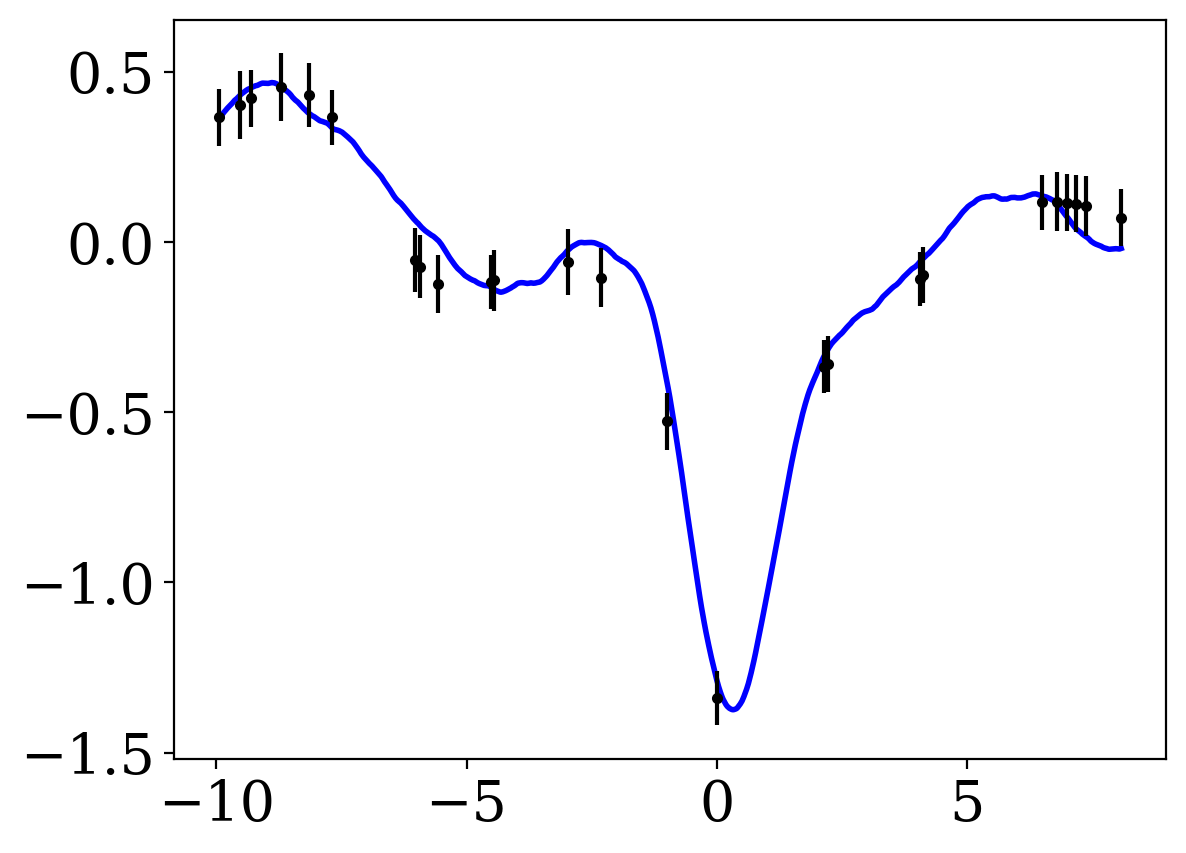

In [114]:
plt.plot(res[0], res[1], color='blue', lw=2)
plt.errorbar(t, y, yerr, fmt='.', color='k')